In [1]:
# Core
import os
import cv2
import numpy as np
import pandas as pd
import collections
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications import VGG16,ResNet50


# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2026-01-03 20:00:43.351828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-03 20:00:43.888439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-03 20:00:54.726547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/d/tfgpu/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning:

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('pranavraikokte/covid19-image-dataset',unzip=True)

In [4]:
# Load Training Data (80%)
train_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Validation Data (20%)
val_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Test Data (separate folder)
test_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False
)

Found 251 files belonging to 3 classes.
Using 201 files for training.


I0000 00:00:1767470461.099238  213902 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5590 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [ ]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(32, 128, 128, 3)
(32,)


2026-01-03 20:01:02.575732: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-01-03 20:01:02.802988: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


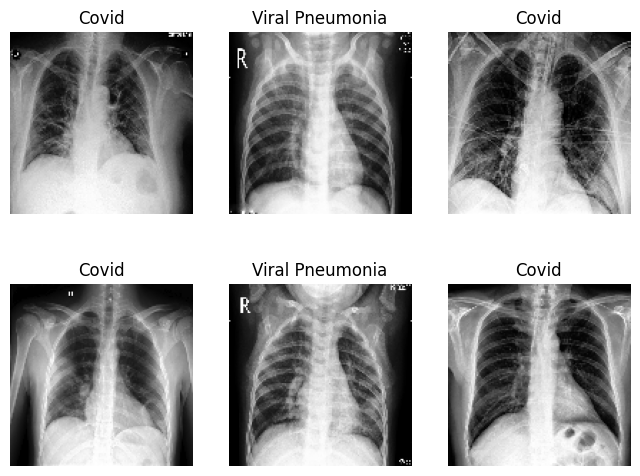

In [7]:
# Sample data
plt.figure(figsize=(8,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

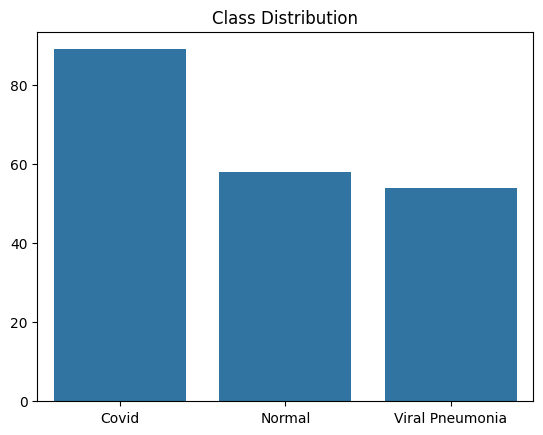

In [8]:
# Class Distribution
label_count = collections.Counter()

for _, labels in train_ds:
    label_count.update(labels.numpy())

sns.barplot(x=list(label_count.keys()),
            y=list(label_count.values()))
plt.xticks(range(len(class_names)), class_names)
plt.title("Class Distribution")
plt.show()

In [9]:
print("Training samples per class:")
for label, count in label_count.items():
    print(f"{class_names[label]}: {count}")

Training samples per class:
Covid: 89
Normal: 58
Viral Pneumonia: 54


---

### 🔍 EDA Observations

* The dataset shows class imbalance across categories.
* COVID-19 and Pneumonia chest X-ray images share visual similarities, making classification challenging.
* Normal chest X-ray images generally exhibit clearer lung structures with fewer dense regions.

---

In [10]:
# Normalizing the images

In [11]:
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [14]:
def evaluate_model(model, test_ds, class_names):
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_true = []
    y_pred_probs = []

    for images, labels in test_ds:
        probs = model.predict(images, verbose=0)
        y_pred_probs.extend(probs)
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    roc_score = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    print(f"\nROC-AUC Score: {roc_score:.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
def plot_history(h):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    ax[0].plot(h.history['accuracy'], label='Train')
    ax[0].plot(h.history.get('val_accuracy', []), label='Val')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(h.history['loss'], label='Train')
    ax[1].plot(h.history.get('val_loss', []), label='Val')
    ax[1].set_title('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Basic CNN

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,667 (22.14 KB)

 Trainable params: 5,667 (22.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2026-01-03 20:01:05.442305: I external/local_xla/xla/service/service.cc:163] XLA service 0x7cae9c00a7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-03 20:01:05.442330: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2026-01-03 20:01:05.497754: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-03 20:01:05.682380: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


1/7 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.2500 - loss: 1.1510

I0000 00:00:1767470468.343227  214152 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 514ms/step - accuracy: 0.3582 - loss: 1.1006 - val_accuracy: 0.4400 - val_loss: 1.0741
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4428 - loss: 1.0725 - val_accuracy: 0.4400 - val_loss: 1.0709
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4428 - loss: 1.0718 - val_accuracy: 0.4400 - val_loss: 1.0711
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4428 - loss: 1.0666 - val_accuracy: 0.4400 - val_loss: 1.0625
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4428 - loss: 1.0655 - val_accuracy: 0.4400 - val_loss: 1.0591
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4428 - loss: 1.0620 - val_accuracy: 0.4400 - val_loss: 1.0597
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4428 - loss: 1.0584 - val_accuracy: 0.4400 - val_loss: 1.0553
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4428 - loss: 1.0503 - val_accuracy: 0.4400 - val_loss: 1.0478
Epoch 9/20
7/7 ━━

2026-01-03 20:01:13.869425: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


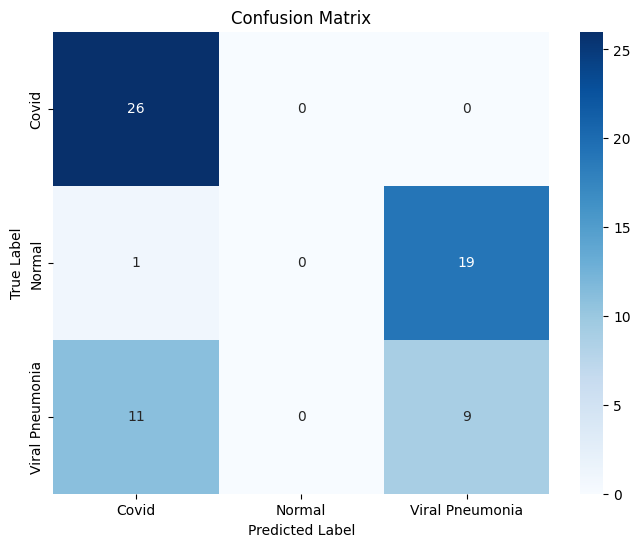

In [16]:
model_basic = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    
    # Conv Block 1
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Conv Block 2
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.GlobalAveragePooling2D(),
    
    # Small Dense Layer
    layers.Dense(16, activation='relu'),
    
    # Output
    layers.Dense(3, activation='softmax')
])

model_basic.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_basic.summary()

# 3. Train
history_basic = model_basic.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, 
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


evaluate_model(model_basic, test_ds, class_names)

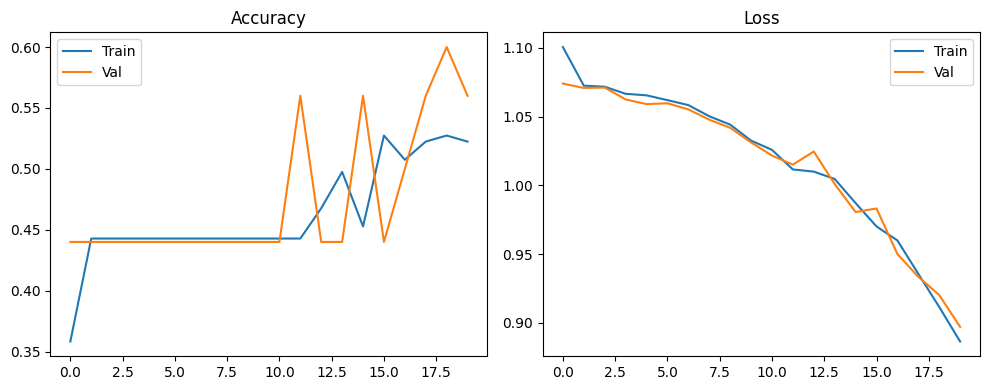

In [17]:
plot_history(history_basic)

# Tuned CNN

In [18]:
model = keras.Sequential([
    # Input Layer (Explicit definition helps with debugging)
    layers.Input(shape=(128, 128, 3)),
    
    # Data Augmentation (Active only during training)
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Classification Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3532 - loss: 1.0911 - val_accuracy: 0.4400 - val_loss: 1.0956 - learning_rate: 1.0000e-04
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4776 - loss: 1.0800 - val_accuracy: 0.4400 - val_loss: 1.0909 - learning_rate: 1.0000e-04
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4328 - loss: 1.0827 - val_accuracy: 0.4400 - val_loss: 1.0875 - learning_rate: 1.0000e-04
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4428 - loss: 1.0753 - val_accuracy: 0.4400 - val_loss: 1.0838 - learning_rate: 1.0000e-04
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4428 - loss: 1.0809 - val_accuracy: 0.4400 - val_loss: 1.0807 - learning_rate: 1.0000e-04
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4428 - loss: 1.0655 - val_accuracy: 0.4400 - val_loss: 1.0778 - learning_rate: 1.0000e-04
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4428 - loss:

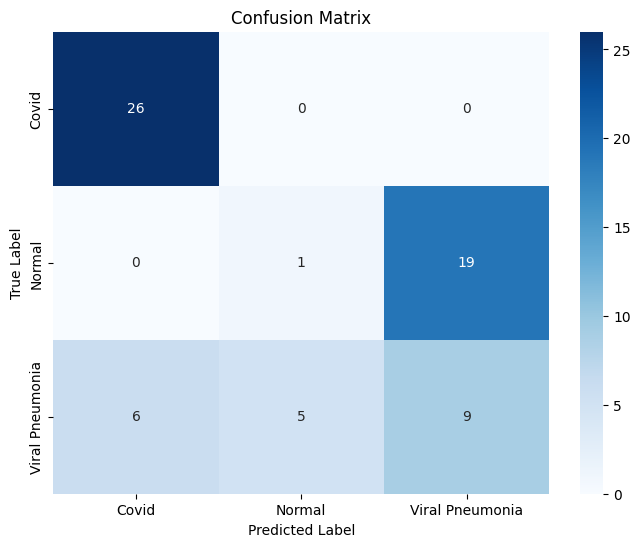

In [19]:
start_time = time.time()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      
    patience=3,       
    min_lr=0.00001   
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stopping, reduce_lr] 
)

end_time = time.time()
total_time = end_time - start_time

print(f"Training time: {total_time:.2f} seconds")
print(f"Training time: {total_time/60:.2f} minutes")

evaluate_model(model, test_ds, class_names)

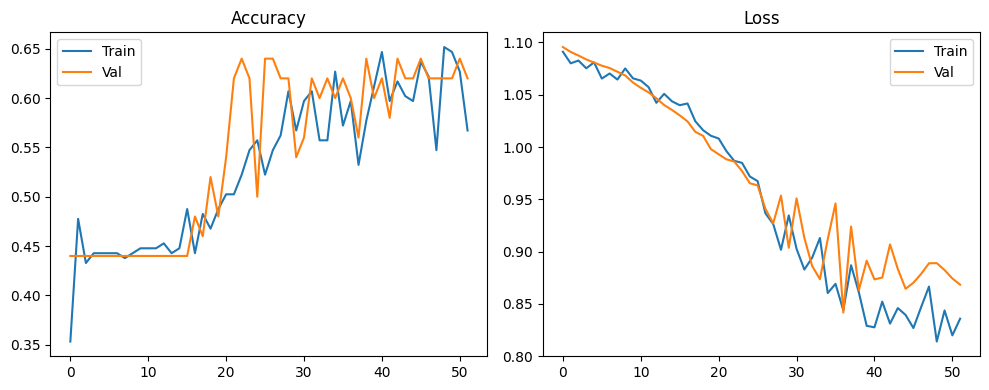

In [20]:
plot_history(history)

# PreTrained Model (VGG16)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.2438 - loss: 1.3328 - val_accuracy: 0.3800 - val_loss: 1.1264
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3284 - loss: 1.2040 - val_accuracy: 0.5000 - val_loss: 1.0790
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3582 - loss: 1.2150 - val_accuracy: 0.4600 - val_loss: 1.0498
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4428 - loss: 1.0918 - val_accuracy: 0.4400 - val_loss: 1.0296
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4677 - loss: 1.0645 - val_accuracy: 0.4400 - val_loss: 1.0146
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4378 - loss: 1.0992 - val_accuracy: 0.4400 - val_loss: 1.0013
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5274 - loss: 1.0408 - val_accuracy: 0.4600 - val_loss: 0.9895
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4677 - loss: 1.0448 - val_accuracy: 0.4600 - val_loss: 0.9787

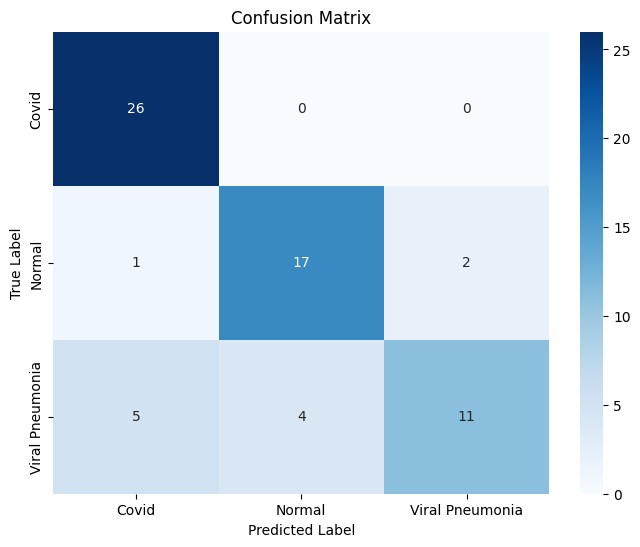

In [21]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(128, 128, 3)
)
base_model.trainable = False # Freeze weights

model_vgg = models.Sequential([
    # Input Layer
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# 3. Compile
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train
history_vgg = model_vgg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

evaluate_model(model_vgg,test_ds,class_names)

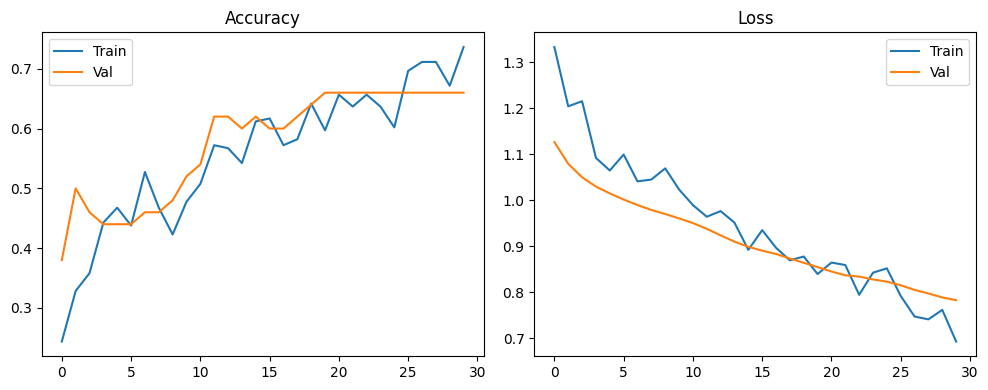

In [22]:
plot_history(history_vgg)

# PreTrained Model (ResNet50)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.2239 - loss: 1.4825 - val_accuracy: 0.2400 - val_loss: 1.2499
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2935 - loss: 1.3355 - val_accuracy: 0.2400 - val_loss: 1.1854
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2935 - loss: 1.3083 - val_accuracy: 0.2400 - val_loss: 1.1412
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3085 - loss: 1.2605 - val_accuracy: 0.2400 - val_loss: 1.1131
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3085 - loss: 1.2452 - val_accuracy: 0.5200 - val_loss: 1.0919
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3582 - loss: 1.1426 - val_accuracy: 0.4400 - val_loss: 1.0800
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3682 - loss: 1.2097 - val_accuracy: 0.4400 - val_loss: 1.0737
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3433 - loss: 1.1819 - val_accuracy: 0.4400 - val_loss: 1.0691

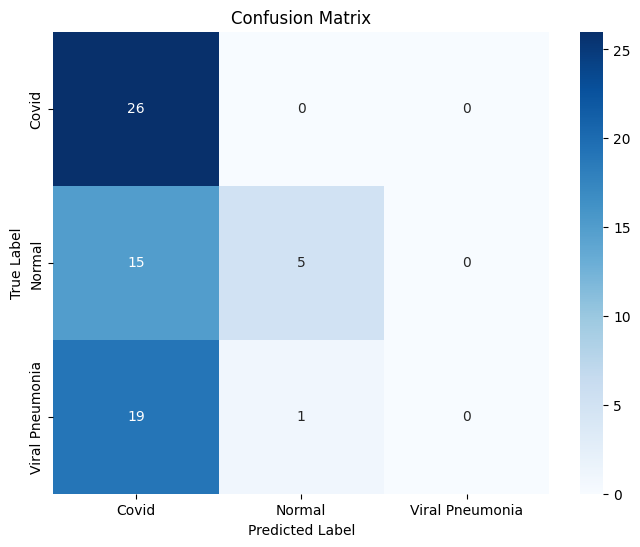

In [23]:
base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(128, 128, 3)
)

base_model_resnet.trainable = False 

# 2. Build Model
model_resnet = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model_resnet,
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# 3. Compile
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

evaluate_model(model_resnet, test_ds, class_names)

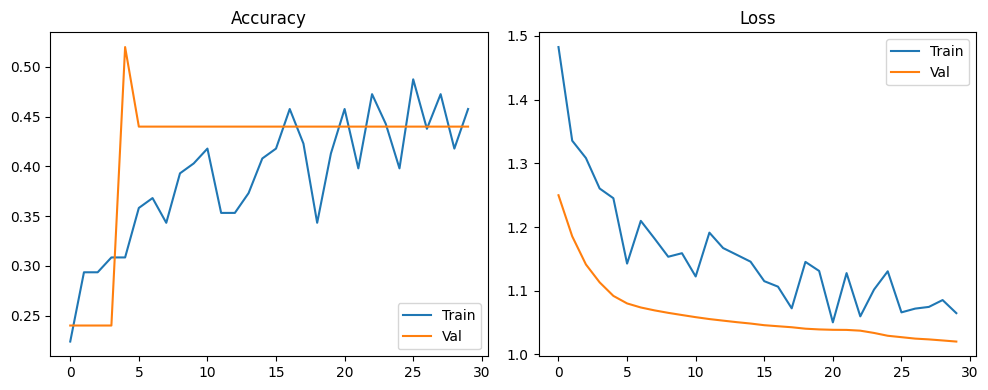

In [24]:
plot_history(history_resnet)

# Best performing model is the VGG16

Test Loss: 0.7229
Test Accuracy: 0.8182

ROC-AUC Score: 0.9479

--- Classification Report ---
                 precision    recall  f1-score   support

          Covid       0.81      1.00      0.90        26
         Normal       0.81      0.85      0.83        20
Viral Pneumonia       0.85      0.55      0.67        20

       accuracy                           0.82        66
      macro avg       0.82      0.80      0.80        66
   weighted avg       0.82      0.82      0.81        66



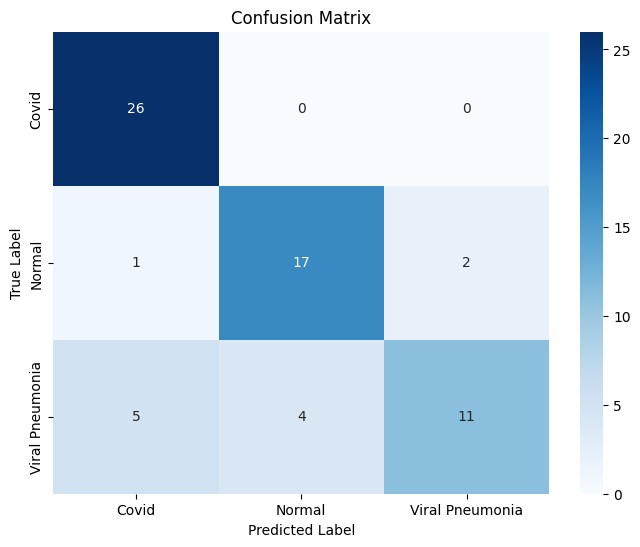

In [41]:
evaluate_model(model_vgg,test_ds,class_names)

In [42]:
model_vgg.save('covid_model.keras') 
print("Model saved as covid_model.keras")

Model saved as covid_model.keras
